In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE

# Data summary
def summary(dtf):
    sumary=pd.concat([dtf.isna().sum(),((dtf == 0).sum())/dtf.shape[0],dtf.dtypes], axis=1)
    sumary=sumary.rename(columns={sumary.columns[0]: 'NaN'})
    sumary=sumary.rename(columns={sumary.columns[1]: 'Zeros'})
    sumary=sumary.rename(columns={sumary.columns[2]: 'Type'})
    sumary['NaN']=sumary['NaN'].astype(str)+' ('+((sumary['NaN']*100/dtf.shape[0]).astype(int)).astype(str)+'%)'
    sumary['Zeros']=(sumary['Zeros']*100).astype(int)
    sumary['Zeros']=(dtf == 0).sum().astype(str)+' ('+sumary['Zeros'].astype(str)+'%)'
    sumary=sumary[['Type','NaN','Zeros']]
    return print(sumary)

# Distribution plot
def dist(dtf,coln, title):
    sns.set(style="white")
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(data=dtf, x=coln, ax=ax_box).set(title=title, xlabel='')
    sns.histplot(data=dtf, x=coln, ax=ax_hist, kde=True, color='blue').set(xlabel='')
    return

def pair_plot(df):
    def corrdot(*args, **kwargs):
        corr_r = args[0].corr(args[1], 'pearson')
        corr_text = f"{corr_r:2.2f}".replace("0.", ".")
        ax = plt.gca()
        ax.set_axis_off()
        marker_size = abs(corr_r) * 10000
        ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
                   vmin=-1, vmax=1, transform=ax.transAxes)
        font_size = abs(corr_r) * 40 + 5
        ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                    ha='center', va='center', fontsize=font_size)
    numerical_columns = df.select_dtypes(include='number').columns
    g = sns.PairGrid(df[numerical_columns])
    g.map_lower(sns.scatterplot, alpha=0.5)
    g.map_diag(sns.histplot, color='blue')
    g.map_upper(corrdot)
    g.fig.suptitle('Pairplot of Numerical Variables', y=1.02)
    plt.show()

In [2]:
df_train = pd.read_csv("/kaggle/input/laptop-price-prediction/laptops_train.csv")
df_test  = pd.read_csv("/kaggle/input/laptop-price-prediction/laptops_test.csv")

# Data Exploration
At a first glance, it is observed that '**Operating System Version**' has zero values (which it should not) and has to be treated further. 

Some columns are formatted as 'Object' when they are supposed to be numerical such as **Screen Size**, **RAM**, **Weight** etc. and they should be treated right away. 

In [3]:
summary(df_train)
df_train.head(5)

                             Type        NaN   Zeros
Manufacturer               object     0 (0%)  0 (0%)
Model Name                 object     0 (0%)  0 (0%)
Category                   object     0 (0%)  0 (0%)
Screen Size                object     0 (0%)  0 (0%)
Screen                     object     0 (0%)  0 (0%)
CPU                        object     0 (0%)  0 (0%)
RAM                        object     0 (0%)  0 (0%)
 Storage                   object     0 (0%)  0 (0%)
GPU                        object     0 (0%)  0 (0%)
Operating System           object     0 (0%)  0 (0%)
Operating System Version   object  136 (13%)  0 (0%)
Weight                     object     0 (0%)  0 (0%)
Price                     float64     0 (0%)  0 (0%)


,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Operating System Version,Weight,Price
0,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,NaN,1.37kg,11912523.48
1,Apple,Macbook Air,Ultrabook,"13.3""",1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,NaN,1.34kg,7993374.48
2,HP,250 G6,Notebook,"15.6""",Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,NaN,1.86kg,5112900.00
3,Apple,MacBook Pro,Ultrabook,"15.4""",IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,NaN,1.83kg,22563005.40
4,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,NaN,1.37kg,16037611.20


# Data Cleansing

This step involves removing substrings from supposingly numerical columns and the splitting of columns containing different elements into separate columns as below:

1. **Screen** - split as the following
   * **Screen Resolution** - We split it further into its Width & Height. Eg. for 1920x1080, Width=1920 and Height=1080.
     
   * **Screen feature** (eg. IPS Display, Touchscreen, Retina Display) - We assign one dummy indicator column for each screen feature to indicate if the laptop has such screen feature.
   
2. **Storage** - Splitted into 4 columns indicating volume of each storage type (HDD, SSD, Flash Storage & Hybrid) , each 1TB is converted into 1000GB
   
3. **CPU** - splitted as the following
    * **CPU Generation** separately for each series eg. AMD A7/A8/A9 or Intel Core i3/i5/i7
    * **CPU Version** - 4 digit numbers at the end eg. Intel core i5 **7200**U, AMD A9-Series **9420**
    * **CPU Cores** for Intel Celeron & Pentium, where Dual Core and Quad Core means 2 & 4 respectively.
    * **CPU Speed** in GHz


4. **GPU** - splitted into versions for each series eg. GeForce, Quadro, Firepro, Radeon, Intel Graphics.

5. Creating a new **Total_Storage** feature - Although we have segregated the SSD and HDD capacities, we should also consider the joint effect of their total capacity.



In [6]:
df=pd.concat([df_train,df_test])

# Splitting "GPU" column
df['GPU'] = df['GPU'].str.replace(r"Nvidia G\D+\s*", "Nvidia GeForce ", regex=True)
df['GeForce_ver'] = df['GPU'].str.extract(r"(?<=Nvidia GeForce\s)(\d+)").astype(float)
df['GPU'] = df['GPU'].str.replace(r"Quadro M", "Quadro ", regex=True)
df['Quadro_ver'] = df['GPU'].str.extract(r"(?<=Nvidia Quadro\s)(\d+)").astype(float)
#df['IntelGPU_ver'] = df['GPU'].str.extract(r"\bIntel\b.*?(\d+)")
df['IntelGPU_ver'] = df['GPU'].str.extract(r"Intel\s+\D*(\d+)").astype(float)
df['GPU'] = df['GPU'].str.replace(r"AMD Radeon RX", "AMD Radeon R10", regex=True)
df['Radeon_Gen'] = df['GPU'].str.extract(r"(?<=Radeon R)(\d+)").astype(float)
df['Radeon_ver'] = df['GPU'].str.extract(r"Radeon.+([\d]{3})") .astype(float)
df['FirePro_ver'] = df['GPU'].str.extract(r"(?<=AMD FirePro W)(\d+)") .astype(float)

# Splitting "CPU" column
df['AMD_A_Gen']=df['CPU'].str.extract(r'(?<=AMD A)(\d+)').astype(float)
df['AMD_A_ver']=df['CPU'].str.extract(r'(?<=AMD A).*(\d{4})').astype(float)
df['AMD_E_ver']=df['CPU'].str.extract(r'(?<=AMD E).*(\d{4})').astype(float)
df['AMD_FX_ver']=df['CPU'].str.extract(r'(?<=AMD FX).*(\d{4})').astype(float)
df['AMD_Ryzen_ver']=df['CPU'].str.extract(r'(?<=AMD Ryzen).*(\d{4})').astype(float)
df['Intel_Atom_ver']=df['CPU'].str.extract(r'(?<=Intel Atom).*(\d{4})').astype(float)
df['Intel_Celeron_ver']=df['CPU'].str.extract(r'(?<=Intel Celeron).*(\d{4})').astype(float)
df['Intel_Celeron_Cores']=df['CPU'].str.extract(r'(?<=Celeron\s)(\w*)').replace({'Quad': 4, 'Dual':2})
df['Intel_Core_i_Gen']=df['CPU'].str.extract(r'(?<=Intel Core [iI])(\d+)').astype(float)
df['Intel_Core_i_ver']=df['CPU'].str.extract(r'(?<=Intel Core [iI]).*(\d{4})').astype(float)
df['Intel_Pentium_ver']=df['CPU'].str.extract(r'(?<=Intel Pentium).*(\d{4})').astype(float)
df['Intel_Pentium_Cores']=df['CPU'].str.extract(r'(?<=Pentium\s)(\w*)').replace({'Quad': 4, 'Dual':2})
df['Intel_Xeon_ver']=df['CPU'].str.extract(r'(?<=Intel Xeon).*(\d{4})').astype(float)
df['CPU_Speed']=df['CPU'].str.rsplit(n=1).str.get(-1).str.replace('GHz', '').astype(float)

# Splitting "Screen" column
df['Screen Size']=df['Screen Size'].str.replace('"', '').astype(float)
df['Resolution_1']=df['Screen'].str.rsplit('x', n=1).str[0].str[-4:].astype(int)
df['Resolution_2']=df['Screen'].str.rsplit('x', n=1).str[1].str[-4:].astype(int)
df['IPS Panel'] = (df['Screen'].str.contains('IPS Panel')).astype(int)
df['Touchscreen'] = (df['Screen'].str.contains('Touchscreen')).astype(int)
df['Retina Display'] = (df['Screen'].str.contains('Retina Display')).astype(int)

# Splitting "Storage" into HDD, SSD, Flash Storage & hybrid storage volumes in GB
df['SSD']=df[' Storage'].str.extract(r'\b(\w+)\s+SSD\b')
df['HDD']=df[' Storage'].str.extract(r'\b(\w+)\s+HDD\b')
df['Flash_Storage']=df[' Storage'].str.extract(r'\b(\w+)\s+Flash\sStorage\b')
df['Hybrid']=df[' Storage'].str.extract(r'\b(\w+)\s+Hybrid\b')
df['HDD']=df['HDD'].str.replace('TB','000GB').str.replace('GB','').fillna(0).astype(int)
df['SSD']=df['SSD'].str.replace('TB','000GB').str.replace('GB','').fillna(0).astype(int)
df['Flash_Storage']=df['Flash_Storage'].str.replace('TB','000GB').str.replace('GB','').fillna(0).astype(int)
df['Hybrid']=df['Hybrid'].str.replace('TB','000GB').str.replace('GB','').fillna(0).astype(int)

# Combine Operating System and its version
df['OS'] = df['Operating System'] + ' ' + df['Operating System Version'].fillna(' ')

# Other misc. cleansing steps
df['RAM']=df['RAM'].str.replace('GB', '').astype(int)
df['Weight']=df['Weight'].str.replace('kgs', '').str.replace('kg', '').astype(float)

# Creating new Total_Storage feature
df['Total_Storage']=df['SSD']+df['HDD']+df['Flash_Storage']+df['Hybrid']

# Filling all NaNs
df.fillna(0, inplace=True)

# Splitting back into train and test data after preprocessing
df_train=df.iloc[0:len(df_train)]
df_test=df.iloc[len(df_train):]

summary(df_train)
df_train.head(5)


                             Type     NaN      Zeros
Manufacturer               object  0 (0%)     0 (0%)
Model Name                 object  0 (0%)     0 (0%)
Category                   object  0 (0%)     0 (0%)
Screen Size               float64  0 (0%)     0 (0%)
Screen                     object  0 (0%)     0 (0%)
CPU                        object  0 (0%)     0 (0%)
RAM                         int64  0 (0%)     0 (0%)
 Storage                   object  0 (0%)     0 (0%)
GPU                        object  0 (0%)     0 (0%)
Operating System           object  0 (0%)     0 (0%)
Operating System Version   object  0 (0%)  136 (13%)
Weight                    float64  0 (0%)     0 (0%)
Price                     float64  0 (0%)     0 (0%)
GeForce_ver               float64  0 (0%)  693 (70%)
Quadro_ver                float64  0 (0%)  951 (97%)
IntelGPU_ver              float64  0 (0%)  466 (47%)
Radeon_Gen                float64  0 (0%)  896 (91%)
Radeon_ver                float64  0 (0%)  864

,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,...,Resolution_2,IPS Panel,Touchscreen,Retina Display,SSD,HDD,Flash_Storage,Hybrid,OS,Total_Storage
0,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,...,1600,1,0,1,128,0,0,0,macOS,128
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,...,900,0,0,0,0,0,128,0,macOS,128
2,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,...,1080,0,0,0,256,0,0,0,No OS,256
3,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,...,1800,1,0,1,512,0,0,0,macOS,512
4,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,...,1600,1,0,1,256,0,0,0,macOS,256


# EDA

**Breakdown of Laptops by Brand**

In this dataset, the greatest quantity of laptops comes from the usual Manufacturers we see on the market:
1. Dell
2. Lenovo
3. Hewlett-Packard (HP)
4. Asus
5. Acer

[Text(0, 0, '232'), Text(0, 0, '226'), Text(0, 0, '179'), Text(0, 0, '122'), Text(0, 0, '83'), Text(0, 0, '39'), Text(0, 0, '34'), Text(0, 0, '17'), Text(0, 0, '8'), Text(0, 0, '7'), Text(0, 0, '6'), Text(0, 0, '5'), Text(0, 0, '4'), Text(0, 0, '3'), Text(0, 0, '3'), Text(0, 0, '3'), Text(0, 0, '2'), Text(0, 0, '2'), Text(0, 0, '2')]


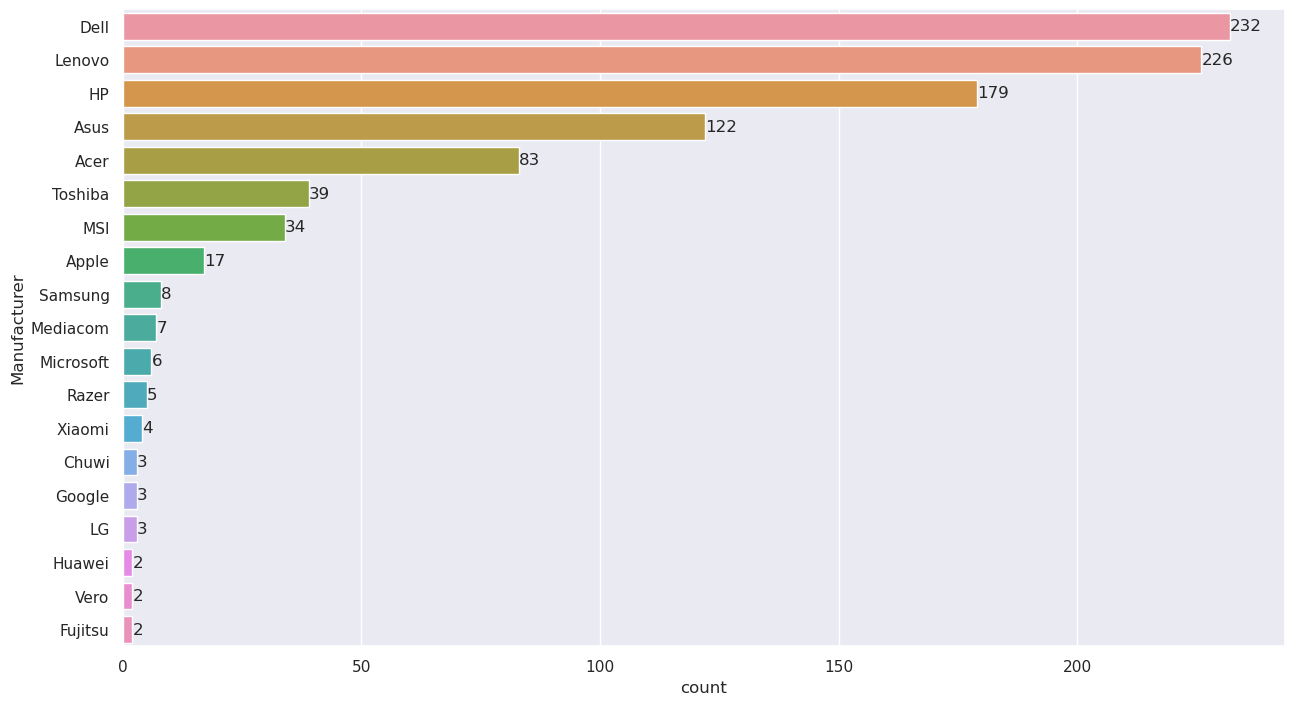

In [9]:
ax=sns.countplot(y=df_train['Manufacturer'], order=df_train['Manufacturer'].value_counts(ascending=False).index)
sns.set(rc={'figure.figsize':(15,8.27)})
print(ax.bar_label(container=ax.containers[0], labels=df_train['Manufacturer'].value_counts(ascending=False).values))

**Price Breakdown by Brand:**

By observing the price distribution of different laptop brands, we can divide the brands into at least 4 different price tiers according to their price range and median price:
* Tier 1   : Vero, Mediacom, Chuwi
* Tier 1.5 : Acer, Fujitsu
* Tier 2   : HP, Dell, Lenovo, Asus, Xiaomi
* Tier 2.5 : Toshiba
* Tier 3   : Huawei, Apple, Microsoft, MSI, Samsung , Google
* Tier 3.5 : LG
* Tier 4   : Razer

AxesSubplot(0.125,0.11;0.775x0.77)


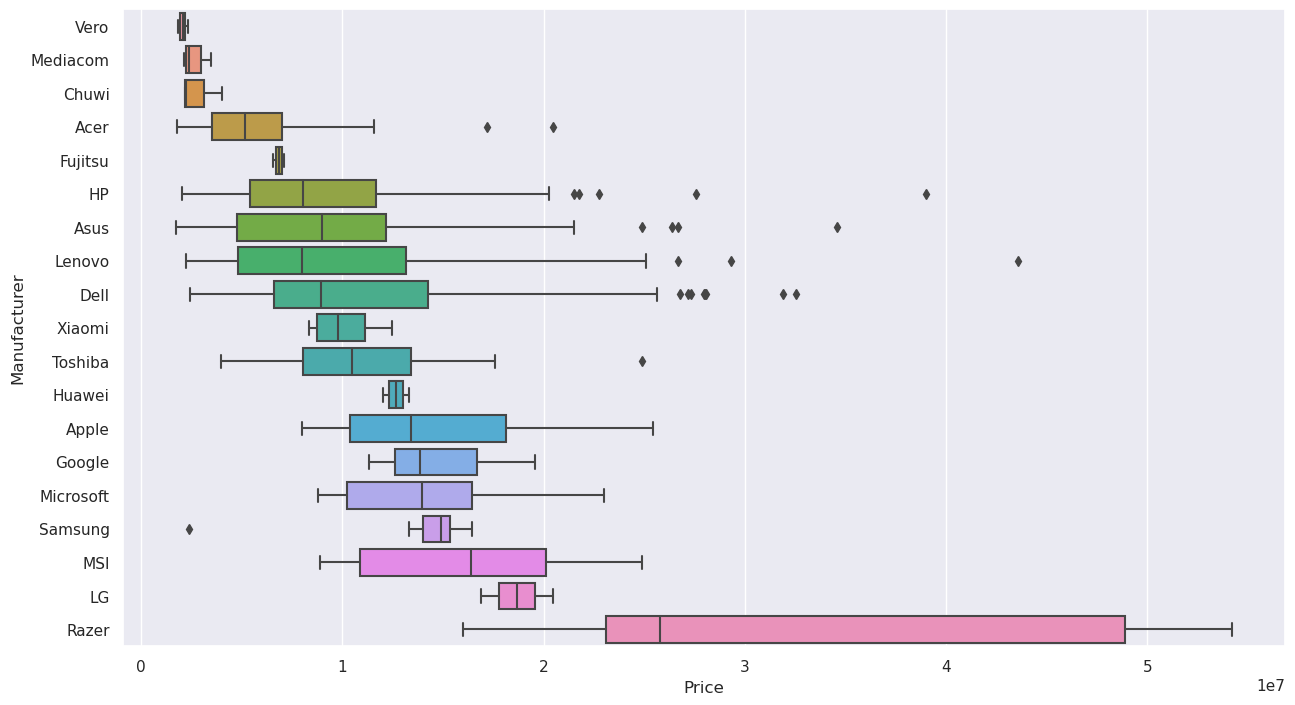

In [10]:
print(sns.boxplot(x=df_train['Price'], y=df_train['Manufacturer'],orient='h', order=["Vero","Mediacom","Chuwi","Acer","Fujitsu","HP","Asus","Lenovo","Dell","Xiaomi","Toshiba","Huawei","Apple","Google","Microsoft","Samsung","MSI","LG","Razer"]))

**Price Breakdown by Laptop Category**

The price difference is obvious between categories, it is observed that *Netbooks* are the cheapest, this is followed by *Notebook* and eventually the costliest laptops are from the *Workstation* Category. 

Besides, the price distribution *Ultrabook* is fairly close to *2 in 1 Convertible* and *Gaming Laptops* are fairly close in terms of either price range or median price.

AxesSubplot(0.125,0.11;0.775x0.77)


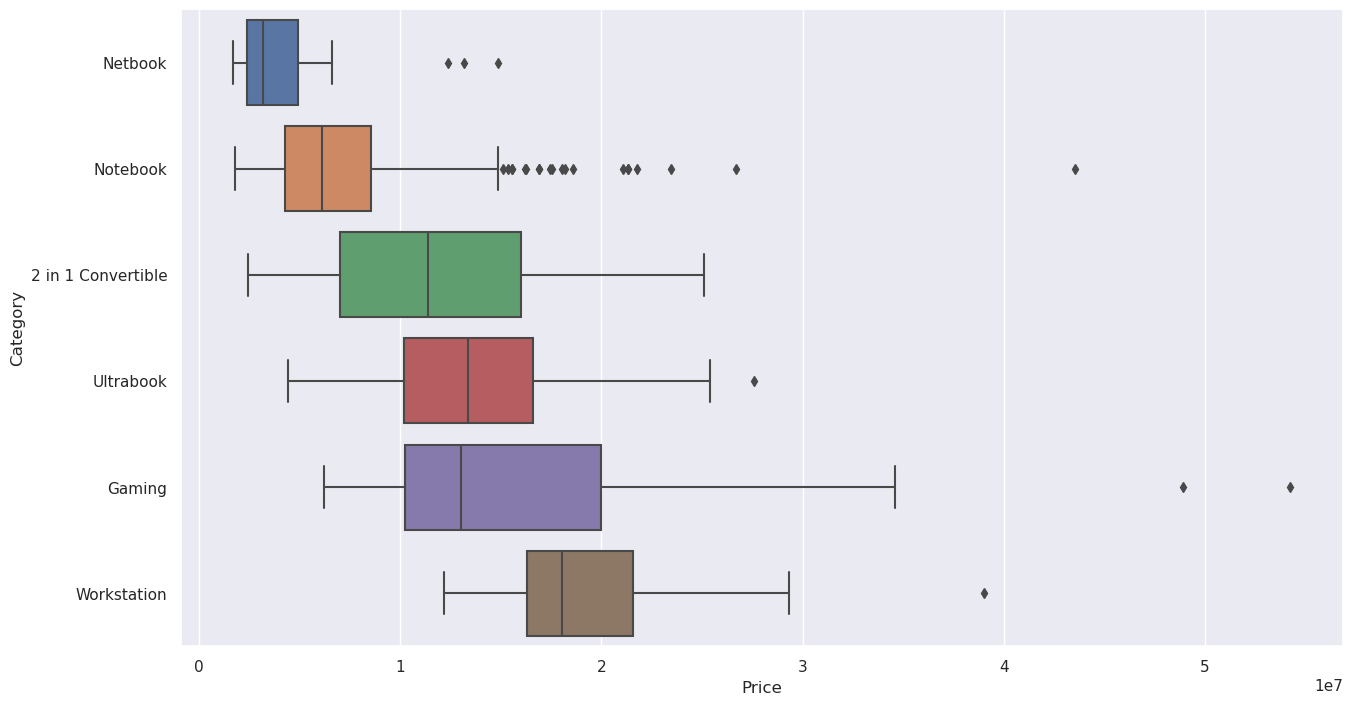

In [11]:
print(sns.boxplot(x=df_train['Price'], y=df_train['Category'],orient='h', order=["Netbook","Notebook","2 in 1 Convertible","Ultrabook","Gaming","Workstation"]))

**Price Breakdown by Operating System Version**



<AxesSubplot:xlabel='Price', ylabel='OS'>

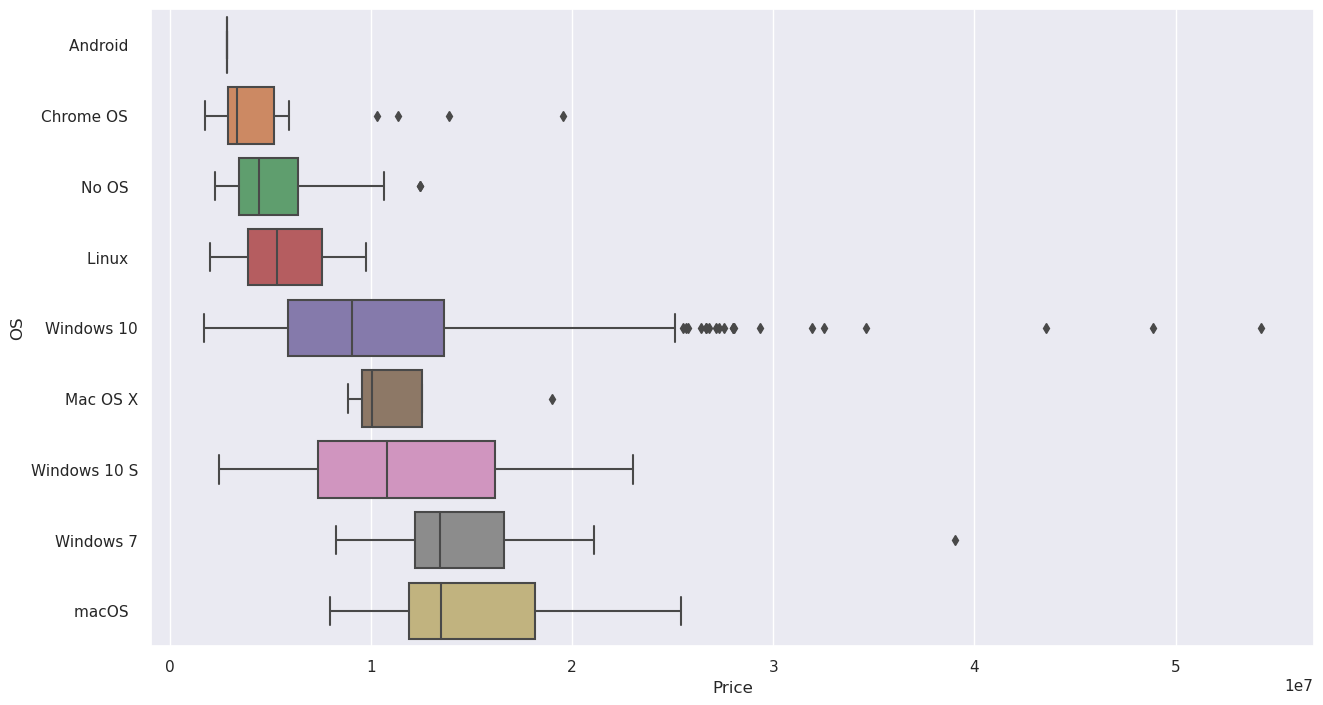

In [12]:
sns.boxplot(x=df_train['Price'], y=df_train['OS'],orient='h', order=["Android  ","Chrome OS  ","No OS  ","Linux  ","Windows 10","Mac OS X","Windows 10 S","Windows 7","macOS  "])

**Qualitative Variable EDA (Correlation)**

We analyse the relationship between numerical variables and the price using a correlation heatmap. 

<AxesSubplot:>

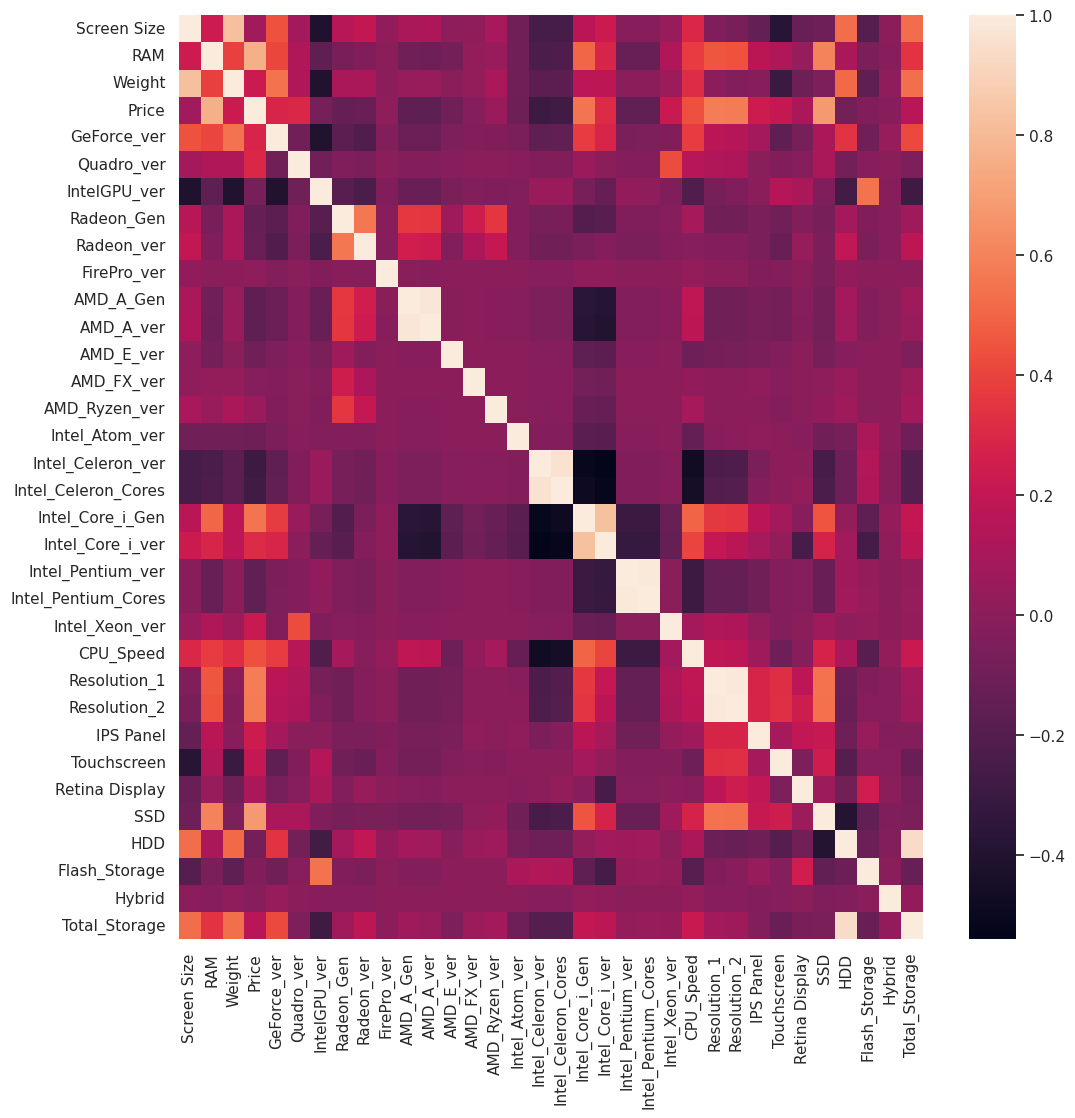

In [13]:
sns.set (rc = {'figure.figsize':(12, 12)})
sns.heatmap(df_train.corr())#, annot=True, fmt=".1f")

By focusing only on variables which are highly correlated with Price, we can deduce the following:

1. **Resolution_1** and **Resolution_2** are perfectly correlated, we will only keep either one (I chose **Resolution_1**, no specific reason here but it's fine if you chose Resolution_2 either).
2. Price is highly positively correlated with **RAM** (r=0.7), **Resolution** (r=0.6) and **SSD** (r=0.7), so we would expect to see laptops with more RAM, higher resolution and greater SSD storage space to be costlier.

<AxesSubplot:>

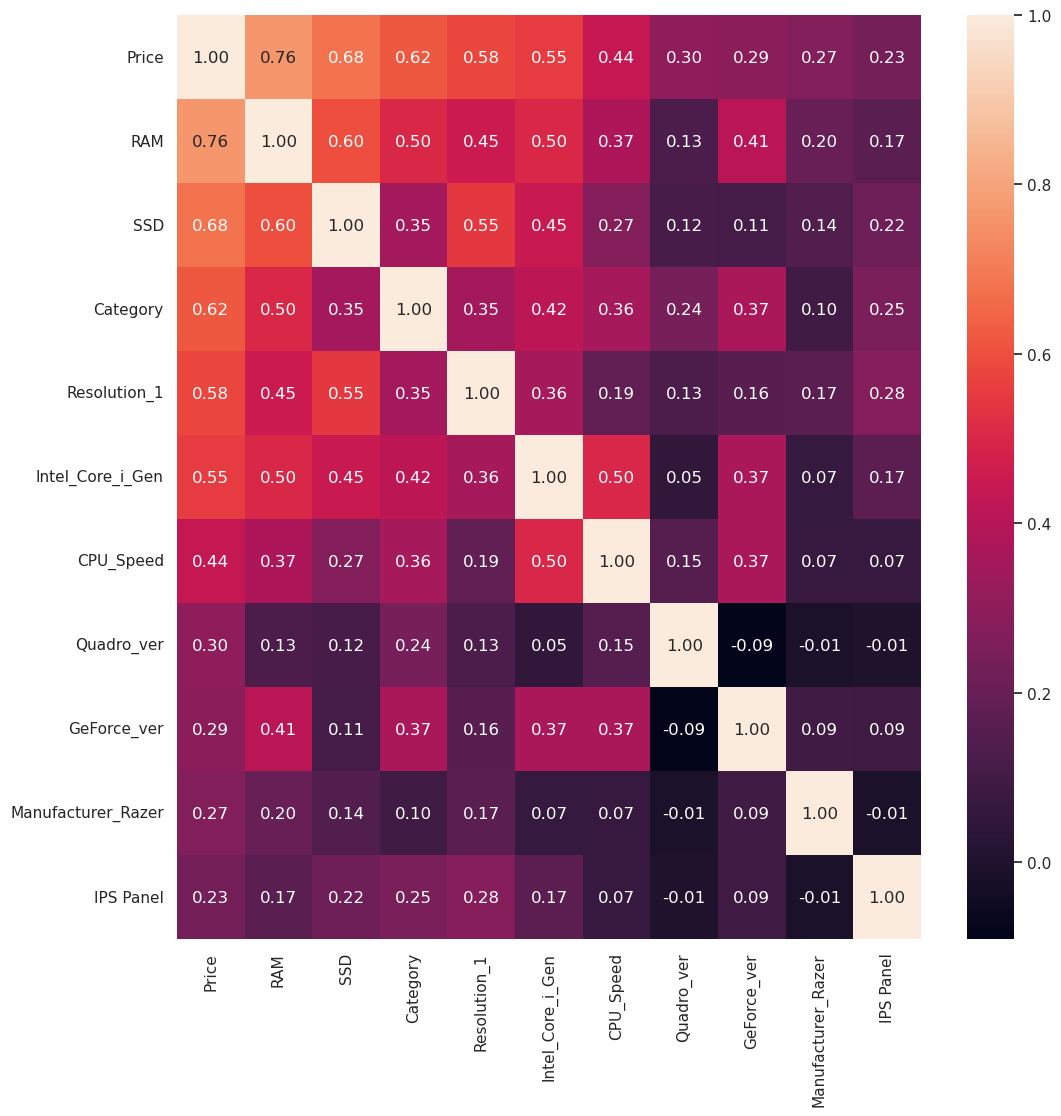

In [21]:
sns.heatmap(df_train[['Price','RAM','SSD','Category','Resolution_1','Intel_Core_i_Gen','CPU_Speed','Quadro_ver','GeForce_ver','Manufacturer_Razer','IPS Panel']].corr(), annot=True, fmt=".2f")

# Data Transformation

Distribution of Weight is observed to be positively skewed. By taking a log-transformation approach, we manage to normalize it despite having a few stubborn outliers.

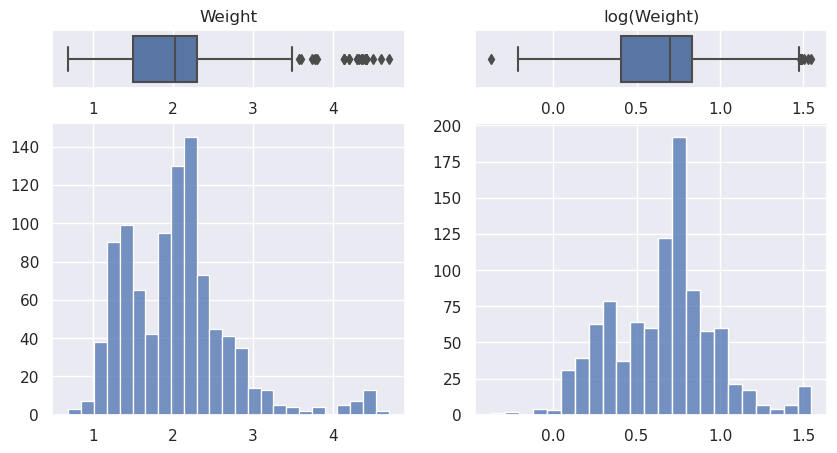

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), gridspec_kw={'height_ratios': [1, 5]})
sns.boxplot(x=df_train['Weight'], orient='h', ax=axs[0, 0])
axs[0, 0].set_xlabel('')
axs[0, 0].set_title('Weight')
sns.histplot(x=df_train['Weight'], ax=axs[1, 0])
axs[1, 0].set_xlabel('')
axs[1, 0].set_ylabel('')
sns.boxplot(x=np.log(df_train['Weight']), orient='h', ax=axs[0, 1])
axs[0, 1].set_xlabel('')
axs[0, 1].set_title('log(Weight)')
sns.histplot(x=np.log(df_train['Weight']), ax=axs[1, 1])
axs[1, 1].set_xlabel('')
axs[1, 1].set_ylabel('')
plt.show()

In [18]:
# Log-transforming Weight feature in both train & test set
df_train['Weight']=np.log(df_train['Weight'])
df_test['Weight']=np.log(df_test['Weight'])

# percentiles = df_train['Weight'].quantile([0.05, 0.95]).values
# df_train['Weight']=np.clip(df_train['Weight'], percentiles[0], percentiles[1])
# percentiles = df_test['Weight'].quantile([0.05, 0.95]).values
# df_test['Weight']=np.clip(df_test['Weight'], percentiles[0], percentiles[1])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Feature Engineering
We will now perform **One-Hot Encoding** on the string columns 'Manufacturer' and 'OS' to assign a binary indicator column for each unique value, and keep only n-1 of those values.

As for the 'Category' feature, it does not have many different values and the EDA earlier showed us that certain laptop categories are higher than each other, so we will do a **Ordinal Encoding** on Category instead.

In [19]:
df = pd.concat([df_train,df_test])

# Version 1 - one hot encode
# df = pd.get_dummies(df, columns = ['Manufacturer','Category','OS'], drop_first=True)
df = pd.get_dummies(df, columns = ['Manufacturer','OS'], drop_first=True)

# Version 2 - just remove
# df.drop(['Manufacturer','Category','OS'], axis=1, inplace=True)

# Version 3 - assign custom rank
# df['Manufacturer']=df['Manufacturer'].replace(['Apple','Huawei','Microsoft','MSI','Samsung','Google'],'3').replace(['Vero','Mediacom','Chuwi'],'1').replace(['Acer','Fujitsu'],'1.5').replace(['HP','Dell','Lenovo','Asus','Xiaomi'],'2').replace(['Toshiba'],'2.5').replace(['LG'],'3.5').replace(['Razer'],'4').astype(float)
df['Category']=df['Category'].replace({ 'Netbook' : 1, 'Notebook' : 2, '2 in 1 Convertible' : 3, 'Ultrabook' : 3.5, 'Gaming' : 4, 'Workstation' : 5 })
# df = pd.get_dummies(df, columns = ['OS'])
# df.drop(['OS_No OS  '],axis=1, inplace=True)


#df.drop(['Model Name','Screen',' Storage','GPU','CPU','Operating System','Operating System Version'],axis=1, inplace=True)
#df.drop(['Resolution_2','Screen Size','Retina Display','HDD','Flash_Storage','Hybrid'],axis=1, inplace=True)

# Splitting back into train and test data
df_train=df.iloc[0:len(df_train)]
df_test=df.iloc[len(df_train):]
df_train.head(5)


,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Operating System Version,...,Manufacturer_Vero,Manufacturer_Xiaomi,OS_Chrome OS,OS_Linux,OS_Mac OS X,OS_No OS,OS_Windows 10,OS_Windows 10 S,OS_Windows 7,OS_macOS
0,MacBook Pro,3.5,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,0,...,0,0,0,0,0,0,0,0,0,1
1,Macbook Air,3.5,13.3,1440x900,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,0,...,0,0,0,0,0,0,0,0,0,1
2,250 G6,2.0,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,0,...,0,0,0,0,0,1,0,0,0,0
3,MacBook Pro,3.5,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,0,...,0,0,0,0,0,0,0,0,0,1
4,MacBook Pro,3.5,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,0,...,0,0,0,0,0,0,0,0,0,1


And in the last step before we train our model, we remove all non-numeric columns.

In [22]:
# Removing string columns
categ_col=['Model Name','Screen','CPU',' Storage','GPU','Operating System','Operating System Version']
df_train = df_train.drop(categ_col, axis=1)
df_test = df_test.drop(categ_col, axis=1)
df_train.head()

,Category,Screen Size,RAM,Weight,Price,GeForce_ver,Quadro_ver,IntelGPU_ver,Radeon_Gen,Radeon_ver,...,Manufacturer_Vero,Manufacturer_Xiaomi,OS_Chrome OS,OS_Linux,OS_Mac OS X,OS_No OS,OS_Windows 10,OS_Windows 10 S,OS_Windows 7,OS_macOS
0,3.5,13.3,8,0.314811,11912523.48,0.0,0.0,640.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,3.5,13.3,8,0.292670,7993374.48,0.0,0.0,6000.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,2.0,15.6,8,0.620576,5112900.00,0.0,0.0,620.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
3,3.5,15.4,16,0.604316,22563005.40,0.0,0.0,0.0,0.0,455.0,...,0,0,0,0,0,0,0,0,0,1
4,3.5,13.3,8,0.314811,16037611.20,0.0,0.0,650.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


# Model Training
With the dataset ready to be trained, we proceed to split the test and train data which were combined earlier for data cleansing. The algorithms will have their hyperparameters tuned using Optuna.

For a training dataset with just 977 entries, we would opt for algorithms which have a higher bias to prevent overfitting. 

Some of the algorithms used here are:
* Linear Regression
* Ridge Regression
* Decision Tree
* Gradient Boost
* Random Forest
* XGBoost
* ElasticNet

In [116]:
import optuna
from sklearn.metrics import r2_score, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn import utils

y_train=df_train['Price']
x_train=df_train.drop(['Price'],axis=1)
y_test=df_test['Price']
x_test=df_test.drop(['Price'],axis=1)

optuna.logging.set_verbosity(optuna.logging.WARNING)

### Baseline Algorithm - Linear Regression
Ideally we would start off by using the simplest **Linear Regression** algorithm as it is the easiest to interpret, although it might not perform as well as other more complex algorithms.

A **10-fold cross validation** will be performed on the training set before experimenting it on the test set to evaluate the model performance, hopefully the performance on the test set would not differ too much from the cross-validation performance otherwise it would be a sign of overfitting.

In [150]:
#from ChatGPT
def objective(trial):
    model = LinearRegression()
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    r2_scorer = make_scorer(r2_score)
    scores = cross_val_score(model, x_train, y_train, cv=kfold, scoring=r2_scorer)
    return np.mean(scores)

# Create and run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
best_params = study.best_params

LR=LinearRegression(**best_params)
LR.fit(x_train, y_train)
y_pred = LR.predict(x_test)
print("Linear Regression Results")
print("R-squared: ", "%.4f" % r2_score(y_test, y_pred))
print("Mean Absolute Error: ", "{0:,.2f}".format(mean_absolute_error(y_test, y_pred)))
print("Root Mean Squared Error: ", "{0:,.2f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))

Linear Regression Results
R-squared:  0.7318
Mean Absolute Error:  2,146,615.12
Root Mean Squared Error:  3,073,002.35


The Linear Regression model was able to fit with 73% R-squared, although not too impressive but it could help us identify the main drivers of the laptop prices.

### An extension to Linear Regression - Ridge Regression (L2)
Since we have 60 features above, the Linear Regression model could be prone to overfitting. This could be mitigated by introducing a L2 regularization factor to surpress less important features.

In [151]:
#from ChatGPT
def objective(trial):
    alpha = trial.suggest_float('alpha', 0.0001, 10.0, log=True)
    
    model = Ridge(alpha=alpha)
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    r2_scorer = make_scorer(r2_score)
    scores = cross_val_score(model, x_train, y_train, cv=kfold, scoring=r2_scorer)
    return np.mean(scores)

# Create and run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
best_params = study.best_params

RR=Ridge(**best_params)
RR.fit(x_train, y_train)
y_pred = RR.predict(x_test)
print("Ridge Regression Results")
print("R-squared: ", "%.4f" % r2_score(y_test, y_pred))
print("Mean Absolute Error: ", "{0:,.2f}".format(mean_absolute_error(y_test, y_pred)))
print("Root Mean Squared Error: ", "{0:,.2f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))

Ridge Regression Results
R-squared:  0.7367
Mean Absolute Error:  2,134,474.55
Root Mean Squared Error:  3,045,033.43


With an R-squared of 74%, there is no significant improvement from the Linear Regression model.

### Decision Tree
The **Decision Tree** is another interpretable algorithm which tells us how it arrives at its predictions starting from the top of the tree, all the way down to it's node.

However there are many parameters here to optimize for the best performance. To handle all these dirty work, we will utilize **Optuna** to find the optimal parameters which yields the **highest R-squared** metric.

In [152]:
#from ChatGPT
def objective(trial):
    # Define the hyperparameters to optimize
    criterion = trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse','absolute_error', 'poisson'])
    #splitter = trial.suggest_categorical('splitter', ['best','random'])
    max_depth = trial.suggest_int('max_depth', 6, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 50)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20)
    #max_features = trial.suggest_categorical('max_features', ['auto','sqrt','log2'])
    #random_state = trial.suggest_int('random_state', 1, 30)

    # Create a decision tree regressor with the suggested hyperparameters
    model = DecisionTreeRegressor(criterion=criterion,
                                  splitter='best',
                                  max_depth=max_depth,
                                  min_samples_split=min_samples_split,
                                  min_samples_leaf=min_samples_leaf,
                                  max_features='auto',
                                  random_state=20
                                 )

    # Perform K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    r2_scorer = make_scorer(r2_score)
    scores = cross_val_score(model, x_train, y_train, cv=kfold, scoring=r2_scorer)
    return np.mean(scores)

# Create and run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
best_params = study.best_params

DT=DecisionTreeRegressor(**best_params)
DT.fit(x_train, y_train)
y_pred = DT.predict(x_test)
print("Decision Tree Results")
print("R-squared: ", "%.4f" % r2_score(y_test, y_pred))
print("Mean Absolute Error: ", "{0:,.2f}".format(mean_absolute_error(y_test, y_pred)))
print("Root Mean Squared Error: ", "{0:,.2f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))

Decision Tree Results
R-squared:  0.7179
Mean Absolute Error:  2,091,154.57
Root Mean Squared Error:  3,151,694.65


### Distance based algorithms - SVM and KNN
For algorithms such as Support Vector Regressor and K-Nearest Neighbors which are sensitive to distance between points, we have to scale them to a fixed ranged before training them.

In [36]:
# Scaling of features
numeric_col=list(x_train.columns)
x_train_scaled=MinMaxScaler().fit_transform(x_train[numeric_col])
x_test_scaled=MinMaxScaler().fit_transform(x_test[numeric_col])

In [144]:
#from ChatGPT
def objective(trial):
    loss=trial.suggest_categorical('loss',['epsilon_insensitive','squared_epsilon_insensitive'])
    tol=trial.suggest_float('tol',0.001,0.1)
    C=trial.suggest_float('C',0.001,1)
    epsilon=trial.suggest_float('epsilon',0.01,0.1)
    fit_intercept=trial.suggest_categorical('fit_intercept',['True','False'])
    intercept_scaling=trial.suggest_float('intercept_scaling',0.001,10)
    max_iter=trial.suggest_int('max_iter',2,1000)
    random_state = trial.suggest_int('random_state', 1, 30)

    # Create a decision tree regressor with the suggested hyperparameters
    model = LinearSVR(loss=loss, 
                      tol=tol, 
                      C=C, 
                      epsilon=epsilon, 
                      fit_intercept=fit_intercept, 
                      intercept_scaling=intercept_scaling, 
                      max_iter=max_iter,
                      random_state=random_state)

    # Perform K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    r2_scorer = make_scorer(r2_score)
    scores = cross_val_score(model, x_train_scaled, y_train, cv=kfold, scoring=r2_scorer)
    return np.mean(scores)

# Create and run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
best_params = study.best_params

SVR=LinearSVR(**best_params)
SVR.fit(x_train_scaled, y_train)
y_pred = SVR.predict(x_test_scaled)
print("Linear SVM Results")
print("R-squared: ", "%.4f" % r2_score(y_test, y_pred))
print("Mean Absolute Error: ", "{0:,.2f}".format(mean_absolute_error(y_test, y_pred)))
print("Root Mean Squared Error: ", "{0:,.2f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))

Linear SVM Results
R-squared:  0.6861
Mean Absolute Error:  2,285,553.15
Root Mean Squared Error:  3,324,633.25


In [145]:
#from ChatGPT
def objective(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
    p = trial.suggest_int('p', 1, 2)
    leaf_size = trial.suggest_int('leaf_size', 1, 50)

    # Create a decision tree regressor with the suggested hyperparameters
    model = KNeighborsRegressor(n_neighbors=n_neighbors, 
                                weights=weights, 
                                algorithm=algorithm,
                                p=p,
                                leaf_size=leaf_size,
                               )

    # Perform K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    r2_scorer = make_scorer(r2_score)
    scores = cross_val_score(model, x_train_scaled, y_train, cv=kfold, scoring=r2_scorer)
    return np.mean(scores)

# Create and run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
best_params = study.best_params

KNN=KNeighborsRegressor(**best_params)
KNN.fit(x_train_scaled, y_train)
y_pred = KNN.predict(x_test_scaled)
print("K-Nearest Neighbors Result")
print("R-squared: ", "%.4f" % r2_score(y_test, y_pred))
print("Mean Absolute Error: ", "{0:,.2f}".format(mean_absolute_error(y_test, y_pred)))
print("Root Mean Squared Error: ", "{0:,.2f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))

K-Nearest Neighbors Result
R-squared:  0.6969
Mean Absolute Error:  2,118,331.90
Root Mean Squared Error:  3,267,188.23


**It seems that the Linear/Ridge Regression model is the ideal model here with the highest R-squared and lowest MAE/RMSE. So we will use it to interpret our results later.**

### Feature Importances
* Contrary to 'our' prior belief, hardware specs are **not** the main factors in determining the laptop prices, but it is instead determined by the **Manufacturer** brands only. 
* From the chart below, we can deduce that the **costliest laptops** are often manufactured by **Razer**, and this is followed by laptops manufactured by **Microsoft**, **Google**, **LG**, and **Huawei**.
* However, this does not mean hardware specifications do not matter at all, as **CPU Speed**, **Category**, and **Weight** still has a minor impact on the prices. 
* **CPU, GPU, Screen**, and **Storage** features do not have a place in determining the prices.

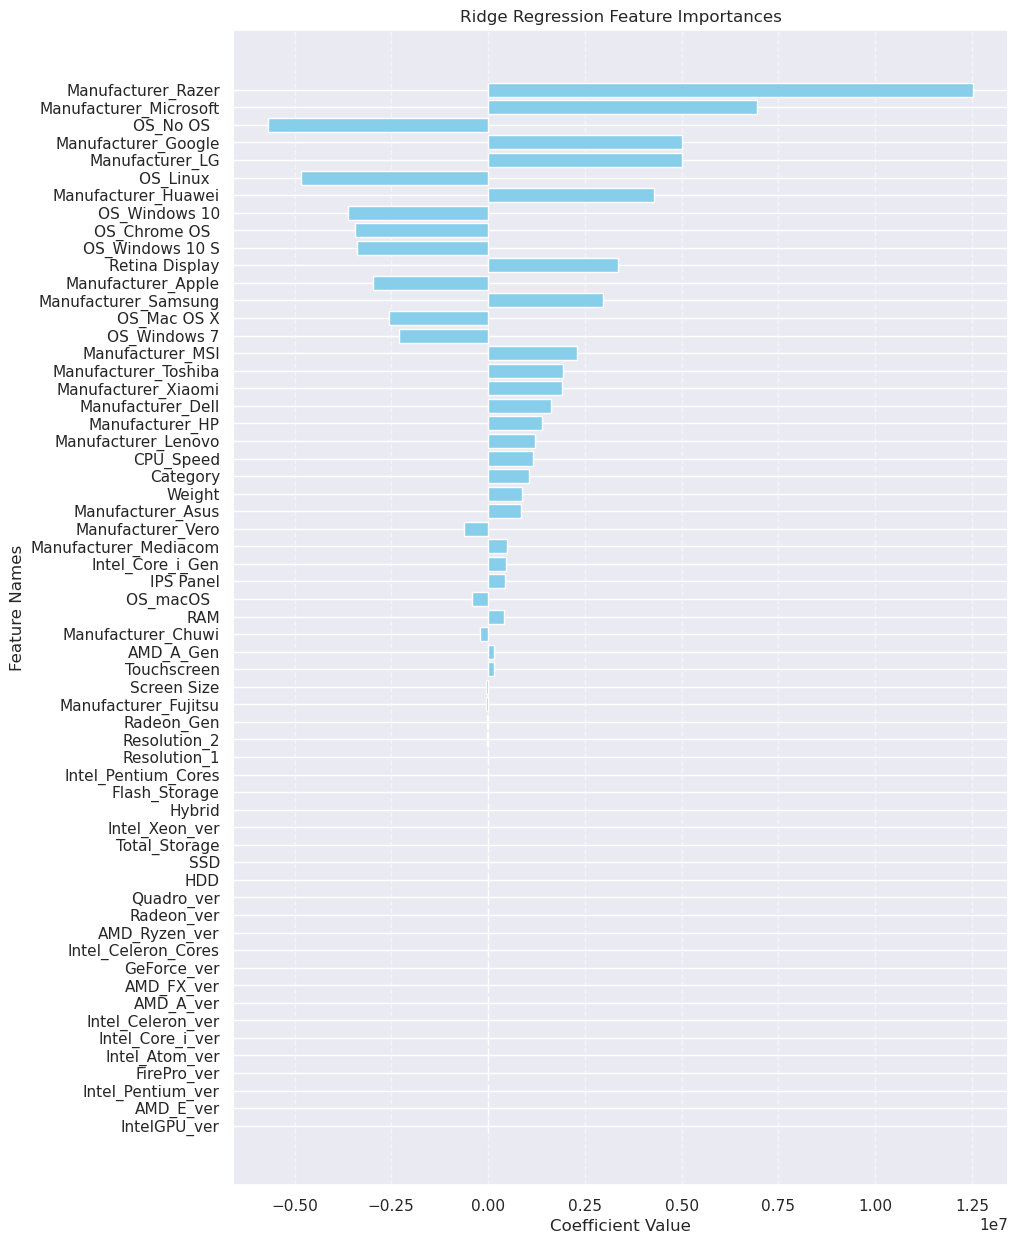

In [29]:
# Plotting
sorted_feature_coefficients = sorted(zip(x_train.columns, LR.coef_), key=lambda x: abs(x[1]), reverse=False)
sorted_feature_names, sorted_coefficients = zip(*sorted_feature_coefficients)
plt.figure(figsize=(10, 15))
plt.barh(sorted_feature_names, sorted_coefficients, color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Names')
plt.title('Ridge Regression Feature Importances')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

## Ensemble - Random Forest, GBM, LGBM, XGB
Since the previous algorithms does not seem to meet our expectations, if we are merely interested in improving prediction accuracy, we could try out some Ensemble algorithms to improve our predictions:

In [146]:
#from ChatGPT
def objective(trial):
    # Define the hyperparameters to optimize
    criterion = trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse','absolute_error'])#, 'poisson'
    max_depth = trial.suggest_int('max_depth', 5, 15)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20)
    #max_features = trial.suggest_categorical('max_features', ['sqrt','log2'])
    random_state = trial.suggest_int('random_state', 1, 30)
    model = RandomForestRegressor(criterion=criterion, 
                                  max_depth=max_depth, 
                                  min_samples_split=min_samples_split, 
                                  min_samples_leaf=min_samples_leaf, 
                                  max_features='sqrt',
                                  random_state=random_state
                                 )

    # Perform K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    r2_scorer = make_scorer(r2_score)
    scores = cross_val_score(model, x_train, y_train, cv=kfold, scoring=r2_scorer)
    return np.mean(scores)

# Create and run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)
best_params = study.best_params

RF=RandomForestRegressor(**best_params)
RF.fit(x_train, y_train)
y_pred = RF.predict(x_test)
print("Random Forest Results")
print("R-squared: ", "%.4f" % r2_score(y_test, y_pred))
print("Mean Absolute Error: ", "{0:,.2f}".format(mean_absolute_error(y_test, y_pred)))
print("Root Mean Squared Error: ", "{0:,.2f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))

Random Forest Results
R-squared:  0.7349
Mean Absolute Error:  1,953,317.51
Root Mean Squared Error:  3,055,142.42


In [140]:
#from ChatGPT
def objective(trial):
    # Define the hyperparameters to optimize
    loss = trial.suggest_categorical('loss', ['squared_error', 'absolute_error', 'huber'])#, 'quantile'
    criterion = trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse'])
    n_estimators = trial.suggest_int('n_estimators', 5, 50)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20)
    max_features = trial.suggest_categorical('max_features', ['auto','sqrt','log2'])
    #random_state = trial.suggest_int('random_state', 1, 30)

    # Create a decision tree regressor with the suggested hyperparameters
    model = GradientBoostingRegressor(loss=loss, 
                                      criterion=criterion, 
                                      max_depth=max_depth, 
                                      min_samples_split=min_samples_split, 
                                      min_samples_leaf=min_samples_leaf, 
                                      max_features=max_features,
                                      random_state=14
                                     )

    # Perform K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    r2_scorer = make_scorer(r2_score)
    scores = cross_val_score(model, x_train, y_train, cv=kfold, scoring=r2_scorer)
    return np.mean(scores)

# Create and run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)
best_params = study.best_params

GB=GradientBoostingRegressor(**best_params)
GB.fit(x_train, y_train)
y_pred = GB.predict(x_test)
print("Gradient Boosting Results")
print("R-squared: ", "%.4f" % r2_score(y_test, y_pred))
print("Mean Absolute Error: ", "{0:,.2f}".format(mean_absolute_error(y_test, y_pred)))
print("Root Mean Squared Error: ", "{0:,.2f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))

Gradient Boosting Results
R-squared:  0.7208
Mean Absolute Error:  1,917,422.00
Root Mean Squared Error:  3,135,782.16


In [143]:
#from ChatGPT
def objective(trial):
    # Define the hyperparameters to optimize
    num_leaves= trial.suggest_int('num_leaves', 2, 50)
    learning_rate= trial.suggest_float('learning_rate', 0.001, 0.1)
    #feature_fraction= trial.suggest_float('feature_fraction', 0.1, 1.0)
    #bagging_fraction= trial.suggest_float('bagging_fraction', 0.1, 1.0)
    reg_alpha= trial.suggest_float('reg_alpha', 0.0, 1.0)
    reg_lambda= trial.suggest_float('reg_lambda', 0.0, 1.0)
    random_state= trial.suggest_int('random_state', 0, 42)
        
    model = LGBMRegressor(num_leaves=num_leaves, 
                         learning_rate=learning_rate,
                         #feature_fraction=feature_fraction, 
                         #bagging_fraction=bagging_fraction, 
                         reg_alpha=reg_alpha,
                         reg_lambda=reg_lambda,
                         random_state=random_state
                        )

    # Perform K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    r2_scorer = make_scorer(r2_score)
    scores = cross_val_score(model, x_train, y_train, cv=kfold, scoring=r2_scorer)
    return np.mean(scores)

# Create and run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)
best_params = study.best_params

LG=LGBMRegressor(**best_params)
LG.fit(x_train, y_train)
y_pred = LG.predict(x_test)
print("LightGBM Result")
print("R-squared: ", "%.4f" % r2_score(y_test, y_pred))
print("Mean Absolute Error: ", "{0:,.2f}".format(mean_absolute_error(y_test, y_pred)))
print("Root Mean Squared Error: ", "{0:,.2f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))

LightGBM Result
R-squared:  0.7384
Mean Absolute Error:  1,909,419.70
Root Mean Squared Error:  3,035,286.42


In [142]:
#from ChatGPT
def objective(trial):
    # Define the hyperparameters to optimize
    eta = trial.suggest_float('eta', 0.01,0.9)
    #min_child_weights = trial.suggest_float('min_child_weights', 0.1, 1)
    max_depth = trial.suggest_int('max_depth', 5, 20)
    gamma=trial.suggest_float('gamma',0.5,1)
    subsample = trial.suggest_float('subsample', 0.2,1)
    #random_state = trial.suggest_int('random_state', 1, 30)
    model = XGBRegressor(eta=eta, 
                         #min_child_weights=min_child_weights,
                         max_depth=max_depth, 
                         gamma=gamma, 
                         subsample=subsample,
                         reg_lambda=2,
                         random_state=23
                        )

    # Perform K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    r2_scorer = make_scorer(r2_score)
    scores = cross_val_score(model, x_train, y_train, cv=kfold, scoring=r2_scorer)
    return np.mean(scores)

# Create and run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)
best_params = study.best_params

XG=XGBRegressor(**best_params)
XG.fit(x_train, y_train)
y_pred = XG.predict(x_test)
print("XGBoost Results")
print("R-squared: ", "%.4f" % r2_score(y_test, y_pred))
print("Mean Absolute Error: ", "{0:,.2f}".format(mean_absolute_error(y_test, y_pred)))
print("Root Mean Squared Error: ", "{0:,.2f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))

XGBoost Results
R-squared:  0.7771
Mean Absolute Error:  1,805,740.25
Root Mean Squared Error:  2,801,565.01


All ensemble algorithms indeed yielded a better performance than the previous models, with **XGBoost** being the best performer here with **77% R-squared** and **2.8E6 RMSE**.